# Cleaning Melbourne city data - other features
This script cleans the data on a number of different feature types for which there is data for Melbourne.
All data is from: https://data.melbourne.vic.gov.au/  

#### Yearly Building Data
This dataset has info from the City of Melbourne's Census of Land Use and Employment (CLUE). It contains annual counts of the number of buildings, their uses, number of floors, accessibility, and location coordinates. 


#### Bike Dock Locations & Capacities
Until the end of 2019 Melbourne had a bike share system in the city, and this data set includes bike dock locations and capacities.  
Also additional dataset: Melbourne Bike Share Station Readings 2011-2017, which might be useful

#### Landmarks and Points of Interest
This dataset provides the locations of various landmarks and points of interest in the city. 

#### Street lighting
Includes all city owned lighting with the wattage, light type, and location.
Downloaded from: https://data.melbourne.vic.gov.au/City-Council/Feature-Lighting-including-light-type-wattage-and-/4j42-79hg 
Maybe street lighting would be better: https://data.melbourne.vic.gov.au/City-Council/Street-lights-with-emitted-lux-level-council-owned/hg8j-vcww

####  Street furniture

Ideas on other data available at open data website:
* social indicators (affluence of area?); tree canopies (green space?; live music venues; Super Sunday bike count; 
* Metro Train Stations with Accessibility Information (landmarks only has Railway Station', 'Transport Terminal', 'Marina', 'Bridge' under transport sub-themes - mero stations might feature in transport terminal but would need to check); playgrouns? Cafe, restaurant, bistro seats; Bar, tavern, pub patron capacity; taxi ranks; public toilets; bus stop locations; 

#### Code initialisation

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import os
import folium 
from datetime import date, datetime

data_folder_fp = '../../Data/'
cleaned_data_folder_fp = '../../Cleaned_data/'

# Memorials

In [2]:
# Read in data
memorials = pd.read_csv(data_folder_fp + 'OtherFeatures/public-memorials-and-sculptures.csv')
split_data = memorials['Co-ordinates'].str.strip(')').str.strip('(').str.split(', ')
memorials['Latitude'] = split_data.apply(lambda x: x[0])
memorials['Longitude'] = split_data.apply(lambda x: x[1])
memorials.drop('Co-ordinates', axis = 1, inplace = True)
# Check for duplicates
print(memorials.duplicated(subset=['Latitude', 'Longitude']).sum())
memorials = memorials.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(memorials.duplicated(subset=['Latitude', 'Longitude']).sum())
# Save
memorials.to_csv(cleaned_data_folder_fp + 'memorials_clean.csv', header = memorials.columns, index=False)

1
0


# Trees

In [10]:
# Read in data
trees = pd.read_csv(data_folder_fp + 'OtherFeatures/trees.csv', encoding= 'unicode_escape')
# Check for duplicates
print(trees.duplicated(subset=['Latitude', 'Longitude']).sum())
trees = trees.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(trees.duplicated(subset=['Latitude', 'Longitude']).sum())
trees.to_csv(cleaned_data_folder_fp+ 'trees_clean.csv', header = trees.columns, index=False)

17
0


# Drinking fountains
Checked in the spatial plotting script and these do just replicate the fountains in the street furniture dataset

In [11]:
# Read in data
fountains = pd.read_csv(data_folder_fp + 'OtherFeatures/drinking-fountains.csv')
fountains.rename(columns={"lat": "Latitude", "lon": "Longitude"}, inplace = True)
# Check for duplicates
print(fountains.duplicated(subset=['Latitude', 'Longitude']).sum())
fountains = fountains.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(fountains.duplicated(subset=['Latitude', 'Longitude']).sum())
fountains.to_csv(cleaned_data_folder_fp+ 'fountains_clean.csv', header = fountains.columns, index=False)

0
0


# Buildings

In [6]:
# Read in data
buildings = pd.read_csv(data_folder_fp + 'OtherFeatures/Buildings_with_name__age__size__accessibility__and_bicycle_facilities.csv')

# Remove columns not needed
buildings.drop(['Block ID', 'Property ID', 'Base property ID', 'Building name', 'Construction year', 'Location',
                'Street address', 'CLUE small area', 'Refurbished year', 'Has showers', 'Accessibility type description'], axis = 1, inplace = True)
# Rename columns
buildings.rename({'Census year': 'year', 'Number of floors (above ground)': 'n_floors', 
                 'Predominant space use': 'building_use', 'Accessibility type': 'access_type',
                 'Accessibility rating': 'access_rating', 'Bicycle spaces': 'bike_spaces',
                 'x coordinate': 'Longitude', 'y coordinate': 'Latitude'}, axis =1, inplace = True)

# Drop 130 buildings that don't have location coordinates
buildings.dropna(subset = ['Longitude'], axis = 0, inplace = True)

# Keep only buildings from 2010 onwards (as this is when camera data is for)
buildings = buildings[buildings['year'] >= 2010]

# Shorten variable names for access type, and convert the variable to categorical
buildings.access_type = buildings.access_type.replace({'Not determined or not applicable': np.nan, 'Low level of accessibility': 'low', 
                               'Moderate level of accessibility': 'moderate', 'High level of accessibility': 'high'})
cat_type = pd.CategoricalDtype(categories = ['low', 'moderate', 'high'], ordered = True)
buildings.access_type = buildings.access_type.astype(cat_type)

### Removing duplicates
Need to do this for each year, because buildings are duplicated in multiple years.  
First of all, check if there are duplicates within years

In [7]:
for year in buildings['year'].unique():
    this_yr = buildings[buildings['year']==year]
    print(len(this_yr.loc[this_yr.duplicated(subset=['Latitude', 'Longitude']), :]))

2683
2708
2711
2728
2751
2767
2842
2875
2829
2853
2821


There are lots of duplicates so test plotting the first of each duplicated values, and the last to double check they are in exactly same spot.   
They seem to be.

In [8]:
for year in buildings['year'].unique():
    this_yr = buildings[buildings['year']==year]
test_first = this_yr.loc[this_yr.duplicated(keep = 'first',subset=['Latitude', 'Longitude']), :]
test_last = this_yr.loc[this_yr.duplicated(keep = 'last',subset=['Latitude', 'Longitude']), :]

# Plot
f = folium.Figure(width=400, height=400)
melbourne_map = folium.Map(location=[test_first.Latitude.mean(), test_first.Longitude.mean()], zoom_start=13).add_to(f)

# Add two versions of the duplicates
first_fg=folium.FeatureGroup(name='First', show=False)
melbourne_map.add_child(first_fg)
for index, location_info in test_first.iterrows():
    folium.CircleMarker([location_info["Latitude"], location_info["Longitude"]], radius=5, fill = True,
                        color='purple', fill_color="purple", popup = 'first',fill_opacity=1).add_to(first_fg)     
    
second_fg=folium.FeatureGroup(name='Second', show=False)
melbourne_map.add_child(second_fg)
for index, location_info in test_last.iterrows():
    folium.CircleMarker([location_info["Latitude"], location_info["Longitude"]], radius=5, fill = True,
                        color='red', fill_color="red", popup = 'second',fill_opacity=1).add_to(second_fg)      
    
from folium import LayerControl  
# Add layer control
melbourne_map.add_child(LayerControl("topright", collapsed = False))  
melbourne_map

Loop through and for each year, keep just one of the duplicates and add to a new dataframe without the duplicates

In [9]:
buildings_no_duplicates=pd.DataFrame()
for year in buildings['year'].unique():
    print(year)
    this_yr = buildings[buildings['year']==year]
    this_yr = this_yr.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
    buildings_no_duplicates =pd.concat([buildings_no_duplicates,this_yr],axis=0)    

2010
2011
2012
2013
2014
2015
2016
2018
2020
2017
2019


Double check duplicates have been removed

In [10]:
for year in buildings_no_duplicates['year'].unique():
    this_yr = buildings_no_duplicates[buildings_no_duplicates['year']==year]
    print(year, len(this_yr.loc[this_yr.duplicated(subset=['Latitude', 'Longitude']), :]))

2010 0
2011 0
2012 0
2013 0
2014 0
2015 0
2016 0
2018 0
2020 0
2017 0
2019 0


#### Check for variables with missing values
Columns which have a high proportion of NULL should perhaps be dropped

In [11]:
round(buildings.isnull().sum()/len(buildings) * 100,1)
buildings['access_type'].value_counts(dropna = False)

NaN         96615
low         30482
high        19077
moderate     6390
Name: access_type, dtype: int64

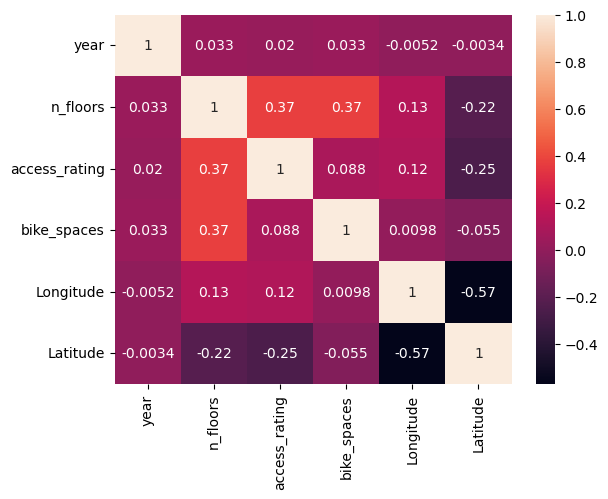

In [14]:
# see correlations
import seaborn as sns
sns.heatmap(buildings.corr(), annot = True);

### Consolidate categories

In [19]:
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(["Residential Apartment", 'House/Townhouse', 'Commercial Accommodation',
                                'Student Accommodation', 'Institutional Accommodation']), "building_use"] = "Residential"
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].str.contains('Unoccupied'), "building_use"] = "Unoccupied"
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(['Retail - Shop', 'Retail - Stall', 'Retail - Showroom', 'Retail - Cars',
                                    'Wholesale']), "building_use"] = "Retail"
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(['Parking - Commercial Covered', 'Parking - Private Covered']),
     "building_use"] = "Parking"
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(['Workshop/Studio', 'Manufacturing', 'Equipment Installation']),
     "building_use"] = "Working"                
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(["Entertainment/Recreation - Indoor"]), "building_use"] = "Entertainment" 
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(["Performances, Conferences, Ceremonies"]), "building_use"] = "Events" 
buildings_no_duplicates.loc[buildings_no_duplicates["building_use"].isin(["Educational/Research"]), "building_use"] = "Education" 

In [20]:
buildings_no_duplicates

year  n_floors building_use access_type  access_rating  bike_spaces  \
350     2010       1.0  Residential         NaN            NaN          NaN   
48802   2010       2.0  Residential         NaN            NaN          NaN   
50075   2010       3.0    Transport         NaN            NaN          NaN   
50200   2010       1.0  Residential         NaN            NaN          NaN   
50275   2010       2.0  Residential         NaN            NaN          NaN   
...      ...       ...          ...         ...            ...          ...   
244030  2019       2.0  Residential         NaN            NaN          NaN   
244032  2019       2.0  Residential         NaN            0.0          NaN   
244034  2019       2.0  Residential         NaN            0.0          NaN   
244035  2019       2.0  Residential         NaN            0.0          NaN   
244036  2019       2.0  Residential         NaN            0.0          NaN   

        Longitude  Latitude  
350      144.9282  -37.7937  
48802    144.9306  -37.7901  
50075    144.9345  -37.7942  
50200    144.9245  -37.7901  
50275    144.9264  -37.7891  
...           ...       ...  
244030   144.9282  -37.7883  
244032   144.9393  -37.7779  
244034   144.9412  -37.7779  
244035   144.9303  -37.7971  
244036   144.9850  -37.8342  

[97371 rows x 8 columns]

#### Save to file

In [24]:
buildings_no_duplicates.to_csv(cleaned_data_folder_fp+ 'SpatialFeatures/buildings_clean.csv', header = buildings.columns, index=False)

# Landmarks & Places of Interest
"This dataset contains a description and co-ordinates of places of interest within the City of Melbourne.

Themes include: Community Use, Education Centre, Health Services, Leisure/Recreation, Mixed Use, Office, Place Of Assembly, Place of Worship, Purpose Built, Retail, Transport, Vacant Land

Sub-themes include: Art Gallery/Museum, Church, Function/Conference/Exhibition Centre, Informal Outdoor Facility (Park/Garden/Reserve), Major Sports & Recreation Facility, Office, Public Buildings, Public Hospital, Railway Station, Retail/Office/Carpark, Tertiary (University), Theatre Live"

In [12]:
# Read in data
landmarks = pd.read_csv(data_folder_fp + 'OtherFeatures/Landmarks_and_places_of_interest__including_schools__theatres__health_services__sports_facilities__places_of_worship__galleries_and_museums..csv')

# Check whether any of the variables have missing data
landmarks.isnull().sum()

# Split co-ordinates into latitude and longitude columns like building data is in
split_data = landmarks['Co-ordinates'].str.strip(')').str.strip('(').str.split(', ')
landmarks['Latitude'] = split_data.apply(lambda x: x[0])
landmarks['Longitude'] = split_data.apply(lambda x: x[1])
landmarks.drop('Co-ordinates', axis = 1, inplace = True)

# Check for duplicates
print(landmarks.duplicated(subset=['Latitude', 'Longitude']).sum())
landmarks = landmarks.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(landmarks.duplicated(subset=['Latitude', 'Longitude']).sum())

# Rename columns
landmarks.rename({'Theme': 'theme', 'Sub Theme': 'sub_theme', 'Feature Name': 'feature_name'}, axis =1, inplace = True)

## Print a summary of the kind of landmarks present in the dataset by theme and subtheme
# landmarks.groupby(['theme', 'sub_theme'])['sub_theme'].count()

# Save to file
landmarks.to_csv(cleaned_data_folder_fp+ 'landmarks_clean.csv', header = landmarks.columns, index=False)

0
0


# Bike Share Locations and capacity
### Even though this program ended in 2019, the docks were in use for the majority of years that this analysis will use
"This dataset show the historical Melbourne Bike Share docks. This program came to an end in November 2019.

Contains the bike share dock locations that were deployed across Melbourne as part of the Melbourne Bike Share Program.

Melbourne Bike Share is a joint RACV/Victorian Government bicycle hire scheme. It allows commuters to hire a bike from a dock location and return it to another dock location in the city. This dataset contains the bike share dock locations and capacity across the city."

#### Clean bike share data

In [13]:
# Read data
bikes = pd.read_csv(data_folder_fp + 'OtherFeatures/Bike_Share_Dock_Locations.csv')
# Check for variables with missing values
bikes.isnull().sum()
# Remove unneeded columns
bikes.drop(['rental_method', 'location', 'name'], axis =1, inplace= True)
# Rename columns
bikes.rename({'lat': 'Latitude', 'lon': 'Longitude'}, axis =1, inplace = True)

# Check for duplicates
print(bikes.duplicated(subset=['Latitude', 'Longitude']).sum())
bikes = bikes.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(bikes.duplicated(subset=['Latitude', 'Longitude']).sum())

#### Save to file
bikes.to_csv(cleaned_data_folder_fp+ 'bikes_clean.csv', header = bikes.columns, index=False)

0
0


# City Lighting
"This dataset contains information such as location, lighting type and wattage of feature lighting across City of Melbourne.

Feature lights are usually found around high profile areas of the city."

#### Clean lighting dataset

In [14]:
# Read data
lights = pd.read_csv(data_folder_fp + 'OtherFeatures/Feature_Lighting__including_light_type__wattage_and_location_.csv')
# Check for variables with missing values
lights.isnull().sum()
# Remove unneeded columns
lights.drop(['asset_number', 'asset_description', 'mounting_type_lupvalue', 'location'], axis = 1, inplace = True)
# Rename columns
lights.rename({'lat': 'Latitude', 'lon': 'Longitude'}, axis =1, inplace = True)

# Check for duplicates
print(lights.duplicated(subset=['Latitude', 'Longitude']).sum())
lights = lights.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)
print(lights.duplicated(subset=['Latitude', 'Longitude']).sum())

#### Save to csv
lights.to_csv(cleaned_data_folder_fp+ 'lights_clean.csv', header = lights.columns, index=False)

437
0


## Street Infrastructure
"The City of Melbourne owns and maintains various objects and pieces of equipment installed on streets and roads for various purposes. This dataset includes Barbeques, Bicycle Rails, Bin Corrals, Bollards, Drinking Fountains, Floral Crate/Planter Boxs, Hoops, Horse Troughs, Information Pillars, Litter Bins, Picnic Setting, Seats."

#### Clean street infrastructure dataset

In [22]:
# Read in data
street_inf = pd.read_csv(data_folder_fp + 'OtherFeatures/Street_furniture_including_bollards__bicycle_rails__bins__drinking_fountains__horse_troughs__planter_boxes__seats__barbecues.csv')

# Check for variables with missing values
street_inf.isnull().sum()

# Drop unneeded columns
street_inf.drop(['GIS_ID', 'DESCRIPTION', 'MODEL_NO', 'MODEL_DESCR', 'DIVISION', 'COMPANY',
                'LOCATION_DESC', 'EVALUATION_DATE', 'EASTING', 'NORTHING', 'UploadDate'], axis = 1, inplace = True)

# Split coordinates into lat/long coordinate columns
split_data = street_inf['CoordinateLocation'].str.strip(')').str.strip('(').str.split(', ')
street_inf['Latitude'] = split_data.apply(lambda x: x[0])
street_inf['Longitude'] = split_data.apply(lambda x: x[1])
street_inf.drop('CoordinateLocation', axis = 1, inplace = True)

# Rename columns to be only lowercase
street_inf.rename({'ASSET_CLASS': 'asset_class', 'ASSET_TYPE': 'feature', 'CONDITION_RATING': 'condition_rating'},
                 axis = 1, inplace = True)

# Drop the asset class as the only value present is street furniture
street_inf.drop('asset_class', axis =1, inplace = True)

# Check for duplicates
print(street_inf.duplicated(subset=['feature','Latitude', 'Longitude']).sum())
street_inf = street_inf.drop_duplicates(subset=['feature','Latitude', 'Longitude'], keep=False)
print(street_inf.duplicated(subset=['feature','Latitude', 'Longitude']).sum())

# Save
street_inf.to_csv(cleaned_data_folder_fp+ 'street_inf_clean.csv', header = street_inf.columns, index=False)

510
0


In [23]:
street_inf

feature  condition_rating             Latitude  \
0      Bicycle Rails              3.12   -37.81618116569443   
1      Bicycle Rails              3.12   -37.80963838054166   
2      Bicycle Rails              3.12   -37.80964511488054   
3            Bollard              4.00   -37.82288176222762   
4      Bicycle Rails              1.17   -37.79456582475606   
...              ...               ...                  ...   
23421     Litter Bin               NaN   -37.80682735918984   
23422     Litter Bin               NaN  -37.842273182670795   
23423  Bicycle Rails               NaN  -37.814947469309054   
23424  Bicycle Rails               NaN   -37.81495183984396   
23425  Bicycle Rails               NaN   -37.81492086816206   

                Longitude  
0      144.96980110865644  
1      144.96091047255698  
2       144.9609142628543  
3       144.9715888259251  
4      144.95349630310034  
...                   ...  
23421  144.94294773255274  
23422   144.9780393211511  
23423  144.96875165736392  
23424   144.9687385876326  
23425  144.96883428912528  

[22486 rows x 4 columns]

In [21]:
street_inf[street_inf['ASSET_TYPE'] == 'Bicycle Rails']['DESCRIPTION'].unique()

array(['Bicycle Rails - Galvanised Steel Bicycle Rail',
       'Bicycle Rails - Stainless Steel Bicycle Rack',
       'Bicycle Rails - Stainless Steel Bicycle Hoop',
       'Bicycle Rails - Painted Steel Bicycle Rail',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - Point Park',
       'Bicycle Rails - Stainless Steel Bicycle Rails ¿ Docklands',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - JJ Holland Park',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - North Melbourne Community Centre (Open Space)',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - Boyd Community Hub',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - State Library of Victoria',
       'Bicycle Rails - Unspecified',
       'Bicycle Rails - Stainless Steel Bicycle Hoop -Warun Biik Park',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - Victoria Green',
       'Bicycle Rails - Stainless Steel Bicycle Hoop - North Melbourne Recreation Reserve',
       'Bicycle Rails - Stainless St

In [19]:
street_inf[street_inf['ASSET_TYPE'] == 'Hoop']['DESCRIPTION'].unique()
# street_inf['feature'].unique()

array(['Hoop - Steel Hoop - Royal Park',
       'Hoop - Steel Hoop - Princes Park',
       'Hoop - Steel Hoop - Alexandra Park',
       'Hoop - Steel Hoop - Alexandra Gardens',
       'Hoop - Steel Hoop - Kings Domain South',
       'Hoop - Stainless Steel Hoop - Royal Park',
       'Hoop - Stainless Steel Hoop - Birrurung Marr',
       'Hoop - Stainless Steel Hoop - Alexandra Park',
       'Hoop - Stainless Steel Hoop - Kings Domain South',
       'Hoop - Stainless Steel Hoop - Shrine Gardens',
       'Hoop - Elongated Steel - Royal Park',
       'Hoop - Barkly Street (CARLTON)', 'Hoop - Powlett Reserve',
       'Hoop - Steel Hoop - Powlett Reserve',
       'Hoop - unspecified - Alexandra Park',
       'Hoop - unspecified - Royal Park'], dtype=object)

# Check for overlaps amongst datasets

In [44]:
memorials = memorials[['Latitude','Longitude' ]].copy()
memorials['Type'] = 'memorials'

landmarks = landmarks[['Latitude','Longitude' ]].copy()
landmarks['Type'] = 'landmarks'

all_transport_stops = pd.concat([landmarks, memorials], axis=0)
all_transport_stops.loc[all_transport_stops.duplicated(keep = False,subset=['Latitude', 'Longitude']), :]

Empty DataFrame
Columns: [Latitude, Longitude, Type]
Index: []